# Задание 

профилирование клиентов банка по историческим транзакционным данным 
* Датасет: https://www.kaggle.com/sokolovaleks/alfabattle2-sandbox
* Необходимо предобработать данные, выделив репрезентативную группу из 100000 активных пользователей.
* Составить профили временной активности для каждого пользователя: суточный (по часам), недельный (по дням) и годовой (по месяцам).
* Составить профили клиентов по тратам.
* Составить профили интересов, опираясь на mcc-коды транзакций. 
* Провести кластеризацию пользователей по всем типам профилей и показать визуализации распределения кластеров в пространстве сниженной размерности. 
* Показать профили по центрам кластеров. Интерпретировать результаты.

## Импорт библиотек

In [ ]:
!pip install pyLDAvis
!pip install gensim

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import gensim
import gensim.corpora as corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['font.size'] = 12
sns.set(font_scale=1.4)

C:\Users\Danila\anaconda3\lib\site-packages\seaborn\rcmod.py:402: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Danila\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


## Чтение данных

In [2]:
file_list = [
    'train_transactions_contest/part_000_0_to_23646.parquet',
    'train_transactions_contest/part_001_23647_to_47415.parquet',
    'train_transactions_contest/part_002_47416_to_70092.parquet',
    'train_transactions_contest/part_003_70093_to_92989.parquet',
    'train_transactions_contest/part_004_92990_to_115175.parquet',
    'train_transactions_contest/part_005_115176_to_138067.parquet',
]

In [3]:
df_list = []

for file in file_list:
    df_list.append(pd.read_parquet(file))
    
df = pd.concat(df_list)

## Выделение репрезентативной группы из 100 000 пользователей

In [4]:
grouped_app_ids = df.groupby('app_id')['app_id'].count()
active_app_ids = grouped_app_ids[grouped_app_ids > 50].index

df = df[df['app_id'].isin(active_app_ids)]

In [5]:
df['app_id'].nunique()

102426

In [36]:
df.head()

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,...,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number,month
0,0,0.465425,1,4,98,4,2,3,7,3,...,1,37,2,4,19,351,34,-1,1,5
1,0,0.000000,1,2,98,7,1,3,7,3,...,1,49,2,4,20,351,34,0,2,5
2,0,0.521152,1,2,98,3,1,3,7,3,...,1,37,2,4,20,351,34,0,3,5
3,0,0.356078,1,1,5,2,1,3,7,3,...,1,49,7,2,0,348,34,52,4,3
4,0,0.000000,1,2,98,7,1,3,7,3,...,1,49,2,4,16,337,53,280,5,7


## Составление профиля временной активности для каждого пользователя: суточный (по часам), недельный (по дням) и годовой (по месяцам).

### Cуточный (по часам)

Explained variation per principal component: [0.57071348 0.12795482]


C:\Users\Danila\anaconda3\lib\site-packages\seaborn\rcmod.py:402: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Danila\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Danila\anaconda3\lib\site-packages\seaborn\axisgrid.py:106: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
C:\Users\Danila\anaconda3\lib\site-packages\seaborn\axisgrid.py:106: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


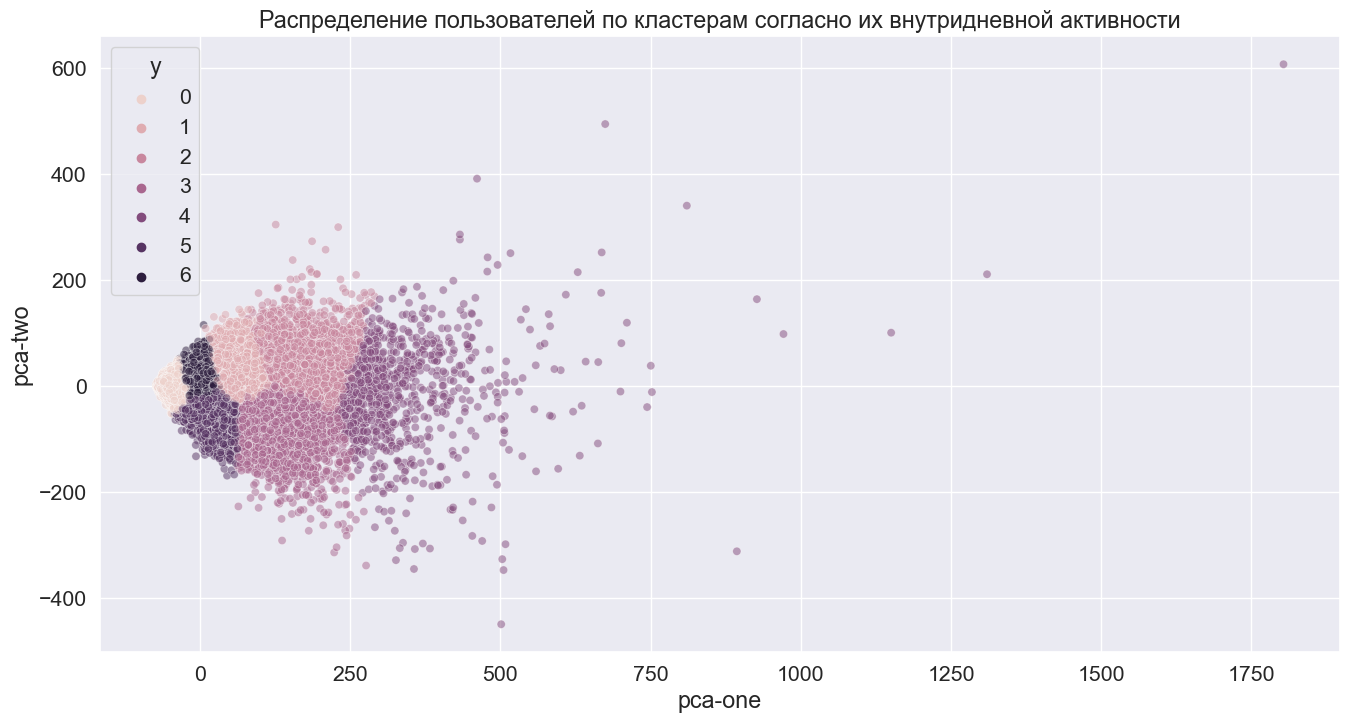

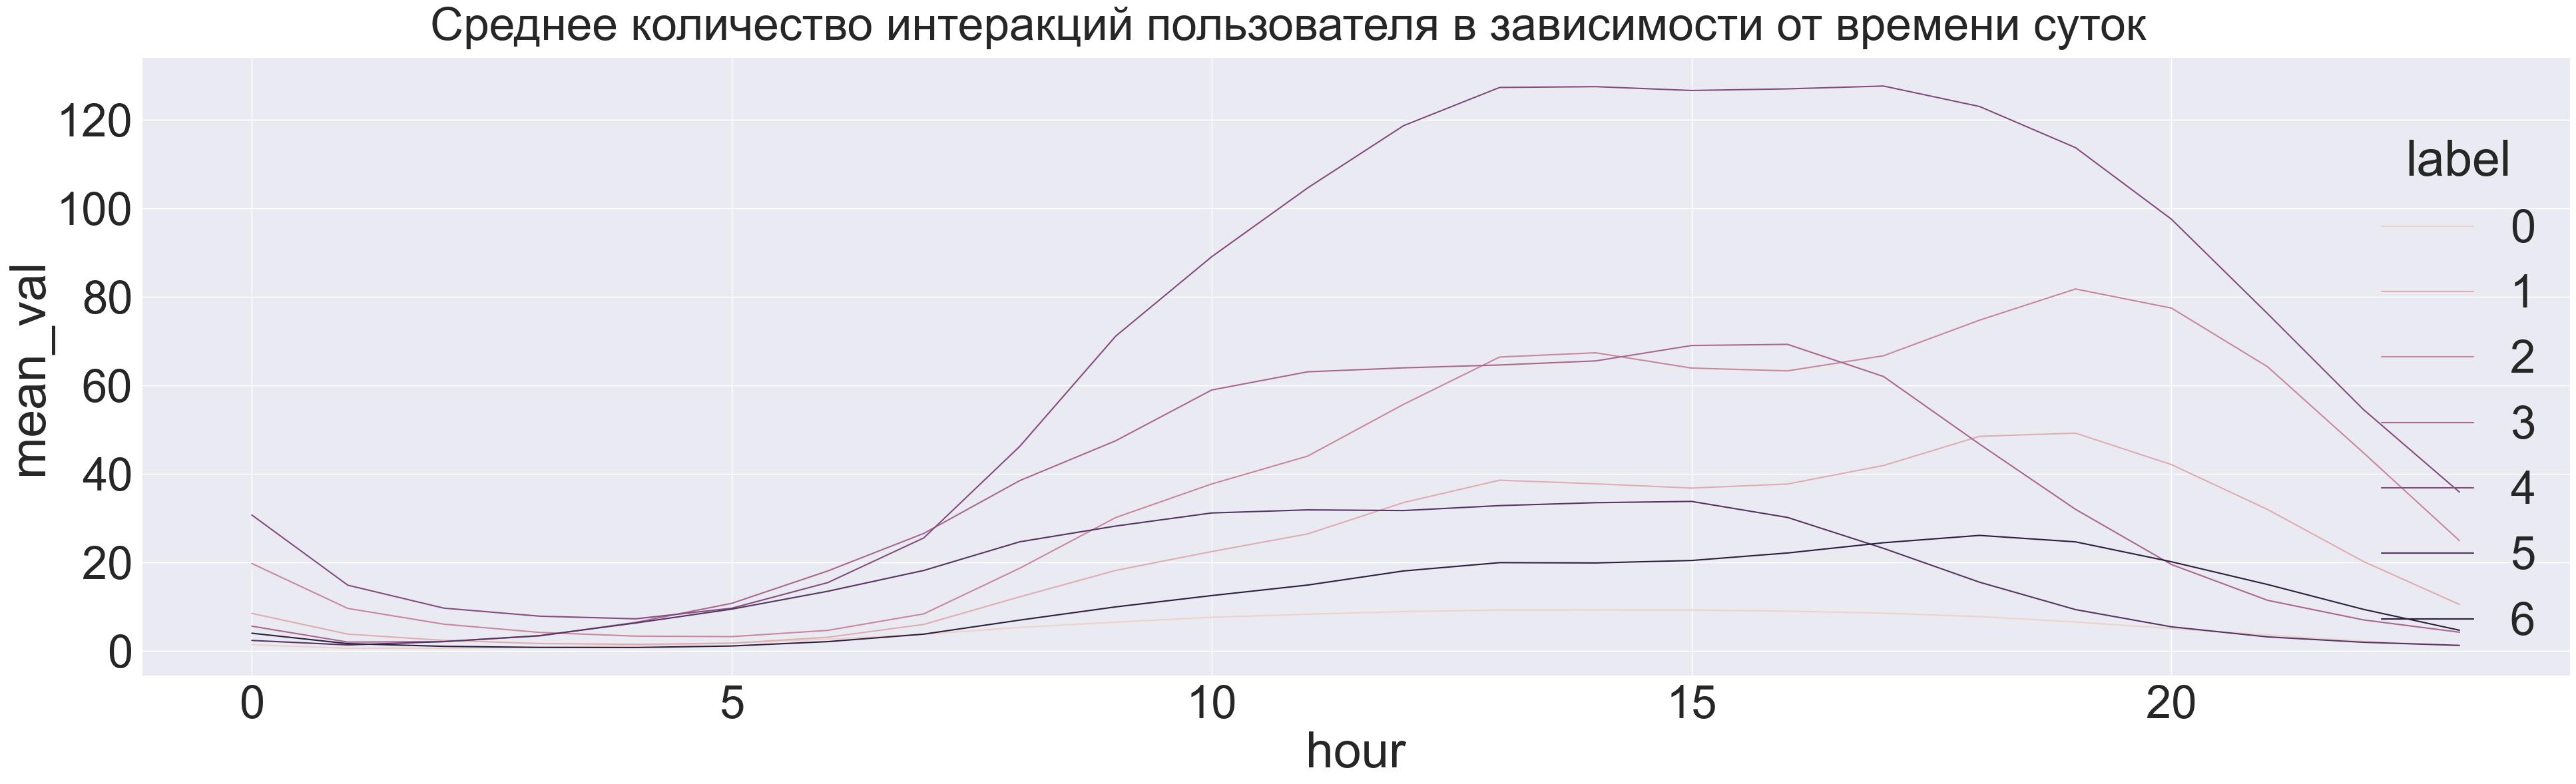

In [7]:
## Группировка по суткам

n_clusters = 7
acceptable_hours = list(range(24))

grouped_df = df.groupby(['app_id', 'hour'])['transaction_number'].count().reset_index(name='n_transaction_number')
grouped_df = grouped_df.groupby(['app_id'])[['hour', 'n_transaction_number']].apply(lambda x: dict(x.values.tolist())).reset_index(name='transcation_per_sth')

grouped_dataset = defaultdict(list)

for app_id, transcation_per_sth in zip(grouped_df['app_id'], grouped_df['transcation_per_sth']):
    grouped_dataset['app_id'].append(app_id)
    
    for col in acceptable_hours:
        grouped_dataset[col].append(transcation_per_sth.get(col, 0))

grouped_df = pd.DataFrame(grouped_dataset)

## Кластеризация
kmeans = KMeans(n_clusters=n_clusters).fit(grouped_df[grouped_df.columns[1:]])
pedicted_clusters =  kmeans.predict(grouped_df[grouped_df.columns[1:]])


grouped_result_df = grouped_df[grouped_df.columns[1:]]
grouped_result_df['y'] = pedicted_clusters
grouped_mean_val = grouped_result_df.groupby('y').mean()

displied_df = pd.DataFrame()
displied_df['hour'] = list(grouped_mean_val.T.index) * len(grouped_mean_val.values)

lables_list = []
mean_value_list = []

for label, mean_values in zip(list(grouped_mean_val.index), kmeans.cluster_centers_):
    for value in mean_values:
        lables_list.append(label)
        mean_value_list.append(value)

displied_df['mean_val'] = mean_value_list
displied_df['label'] = lables_list


## Снижение размерности
pca = PCA(n_components=2)
pca_result = pca.fit_transform(grouped_df[grouped_df.columns[1:]].values)

test_df = pd.DataFrame()
test_df['pca-one'] = pca_result[:,0]
test_df['pca-two'] = pca_result[:,1] 
#test_df['pca-three'] = pca_result[:,2]
test_df['y'] = pedicted_clusters

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

## Отрисовка графиков
fig, ax1 = plt.subplots(1)

ax1.set_title('Распределение пользователей по кластерам согласно их внутридневной активности')
ax1 = sns.scatterplot(
    ax=ax1,
    x="pca-one", y="pca-two",
    hue="y",
    data=test_df,
    legend="full",
    alpha=0.5
)

with sns.plotting_context("notebook", font_scale=4.5):
    ax2 = sns.relplot(data=displied_df, x="hour", y="mean_val", hue="label", kind="line", height=12, aspect=3, legend="full")
    ax2.fig.suptitle('Среднее количество интеракций пользователя в зависимости от времени суток', fontsize=50)

plt.tight_layout()

При распределении пользователей в зависимости от деятельности в разные промежутки времени можно выделить 7 профилей. 
* Все профили обладают повышенной активностью в период с 7 часов утра до полуночи
* 6, 0, 2 профили обладают повышенной активностью с 17 часов до 21 часа и отличаются лишь интенсивностью активности (Возможно люди, пришедшие домой после работы)
* 4 профиль отличается самыми большими тратами за весь промежуток активности
* остальные профили имеют самую большую активность в период с 11 до 18 вечера и отличаются лишь объемом активности (Возможно это люди работающие с этими магазинами)

In [8]:
daily_cluster = pedicted_clusters

### Недельный (по дням)

Explained variation per principal component: [0.93246356 0.03036788]


C:\Users\Danila\anaconda3\lib\site-packages\seaborn\rcmod.py:402: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Danila\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Danila\anaconda3\lib\site-packages\seaborn\axisgrid.py:106: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
C:\Users\Danila\anaconda3\lib\site-packages\seaborn\axisgrid.py:106: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


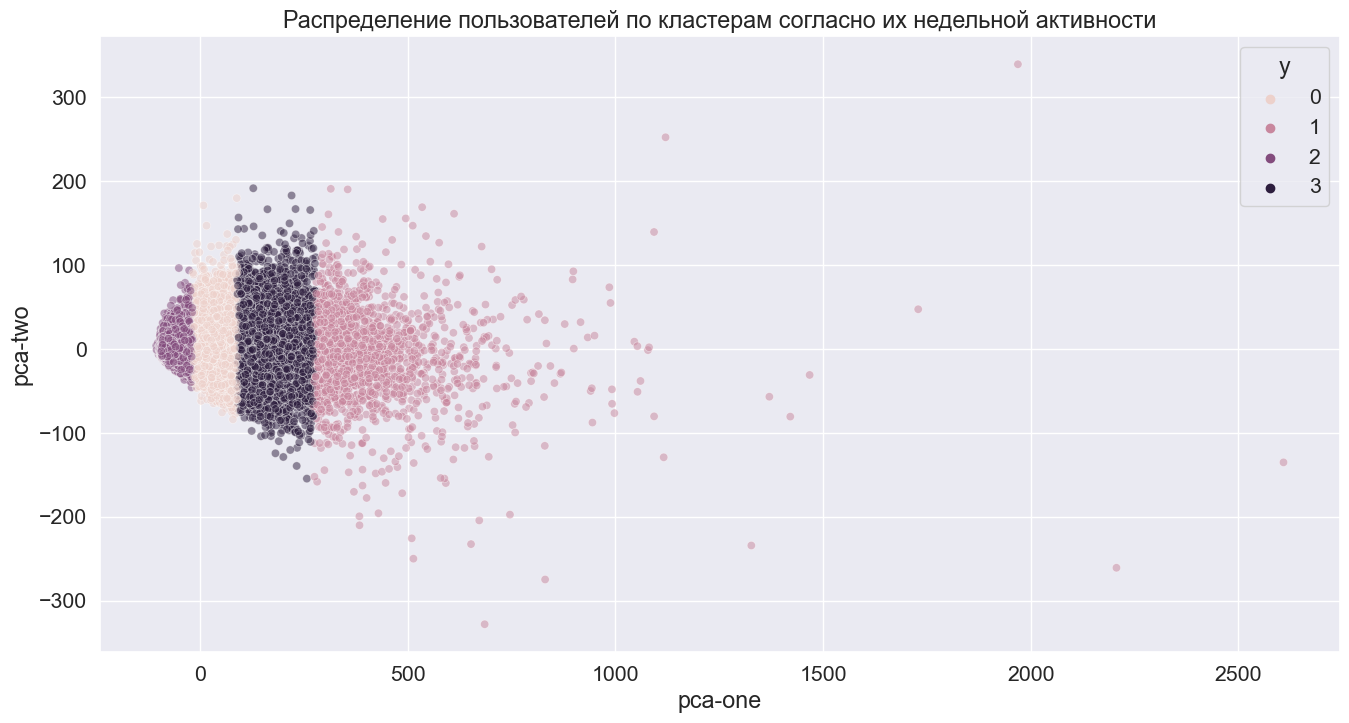

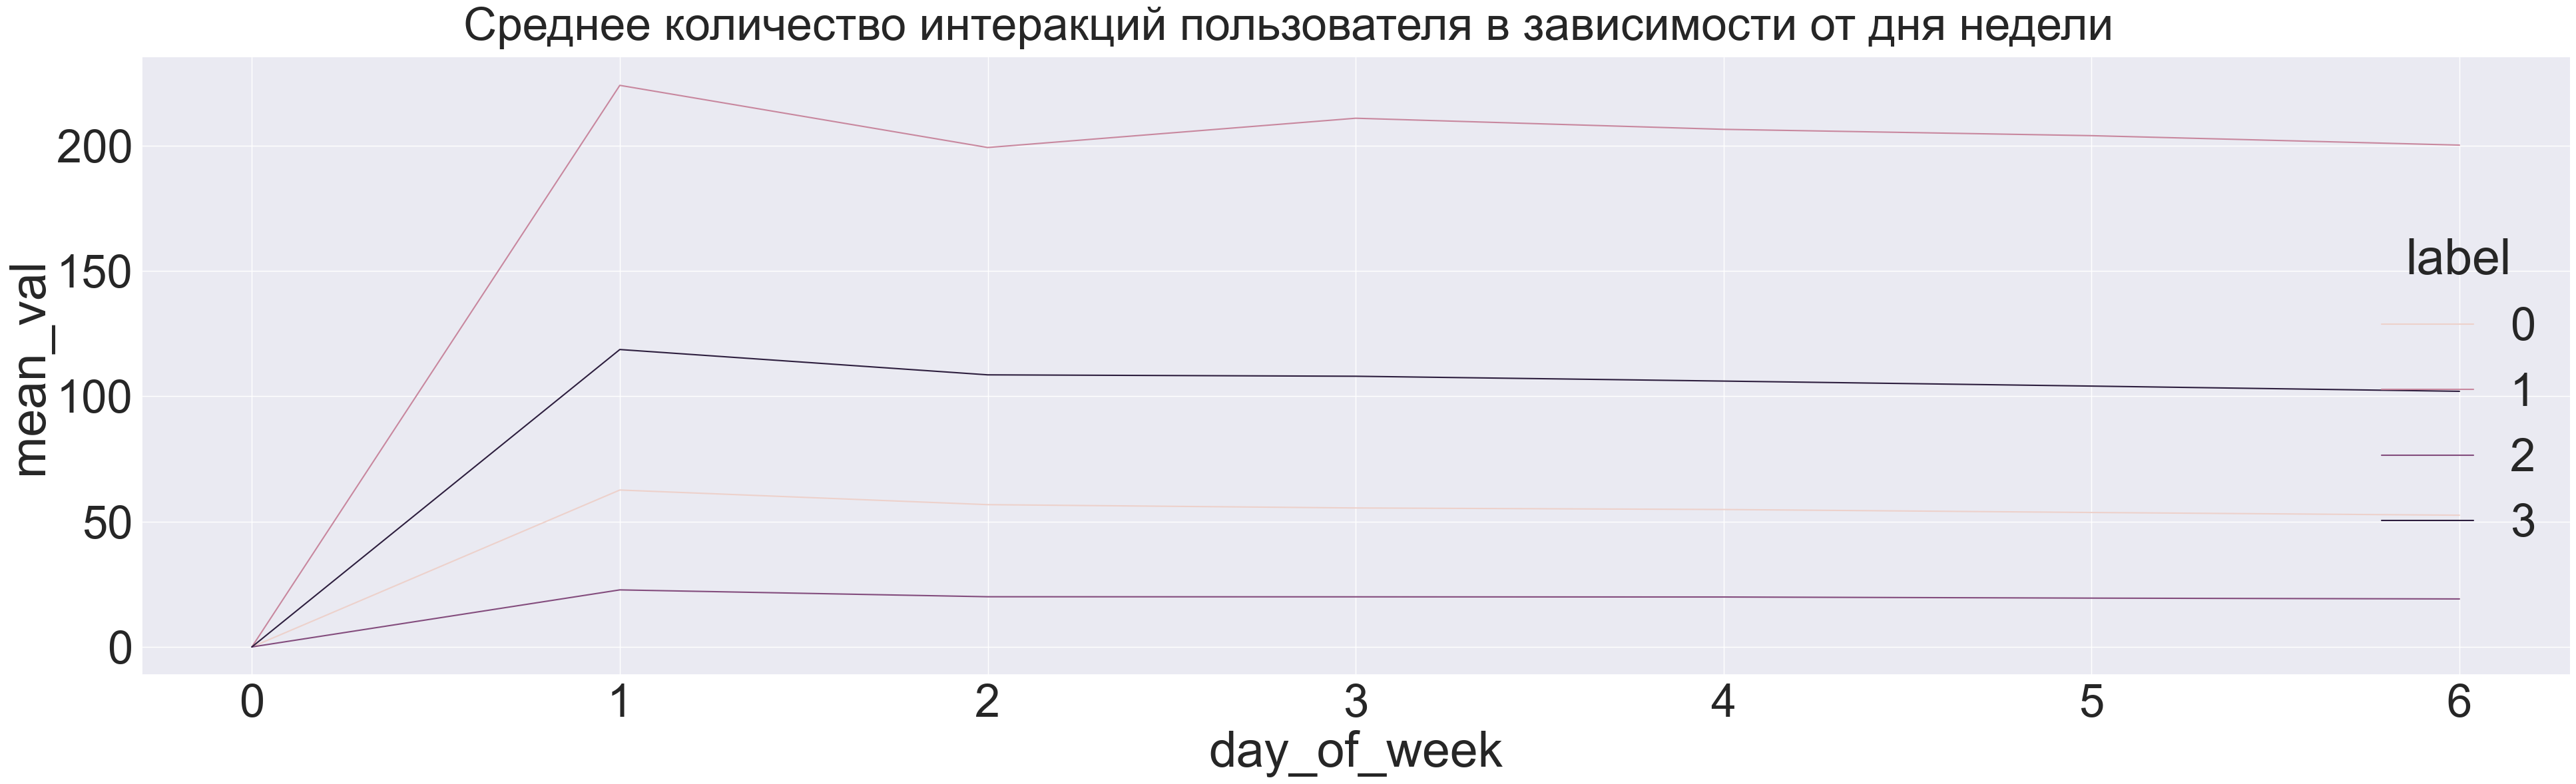

In [9]:
## Группировка по дням недели

n_clusters = 4 
acceptable_hours = list(range(7))

grouped_df = df.groupby(['app_id', 'day_of_week'])['transaction_number'].count().reset_index(name='n_transaction_number')
grouped_df = grouped_df.groupby(['app_id'])[['day_of_week', 'n_transaction_number']].apply(lambda x: dict(x.values.tolist())).reset_index(name='transcation_per_sth')

grouped_dataset = defaultdict(list)

for app_id, transcation_per_sth in zip(grouped_df['app_id'], grouped_df['transcation_per_sth']):
    grouped_dataset['app_id'].append(app_id)
    
    for col in acceptable_hours:
        grouped_dataset[col].append(transcation_per_sth.get(col, 0))

grouped_df = pd.DataFrame(grouped_dataset)

## Кластеризация
kmeans = KMeans(n_clusters=n_clusters).fit(grouped_df[grouped_df.columns[1:]])
pedicted_clusters =  kmeans.predict(grouped_df[grouped_df.columns[1:]])

grouped_result_df = grouped_df[grouped_df.columns[1:]]
grouped_result_df['y'] = pedicted_clusters
grouped_mean_val = grouped_result_df.groupby('y').mean()

displied_df = pd.DataFrame()
displied_df['day_of_week'] = list(grouped_mean_val.T.index) * len(grouped_mean_val.values)

lables_list = []
mean_value_list = []

for label, mean_values in zip(list(grouped_mean_val.index), kmeans.cluster_centers_):
    for value in mean_values:
        lables_list.append(label)
        mean_value_list.append(value)

displied_df['mean_val'] = mean_value_list
displied_df['label'] = lables_list

## Снижение размерности
pca = PCA(n_components=2)
pca_result = pca.fit_transform(grouped_df[grouped_df.columns[1:]].values)

test_df = pd.DataFrame()
test_df['pca-one'] = pca_result[:,0]
test_df['pca-two'] = pca_result[:,1] 

test_df['y'] = pedicted_clusters

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

## Отрисовка графиков
fig, ax1 = plt.subplots(1)

ax1.set_title('Распределение пользователей по кластерам согласно их недельной активности')
ax1 = sns.scatterplot(
    ax=ax1,
    x="pca-one", y="pca-two",
    hue="y",
    data=test_df,
    legend="full",
    alpha=0.5
)

with sns.plotting_context("notebook", font_scale=4.5):
    ax2 = sns.relplot(data=displied_df, x="day_of_week", y="mean_val", hue="label", kind="line", height=12, aspect=3, legend="full")
    ax2.fig.suptitle('Среднее количество интеракций пользователя в зависимости от дня недели', fontsize=50)

plt.tight_layout()

При распределении пользователей в зависимости от деятельности в разные дни недели можно выделить 4 профиля. 
* Все профили обладают повышенной активностью в период со вторника по воскресенье и отличаются лишь интенсивностью активности


In [10]:
weekly_cluster = pedicted_clusters

### Годовой (по месяцам)

In [11]:
df['month'] = (df['day_of_week'] * df['weekofyear'] // 31 + 1)

Explained variation per principal component: [0.93878434 0.02390515]


C:\Users\Danila\anaconda3\lib\site-packages\seaborn\rcmod.py:402: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Danila\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Danila\anaconda3\lib\site-packages\seaborn\axisgrid.py:106: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
C:\Users\Danila\anaconda3\lib\site-packages\seaborn\axisgrid.py:106: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


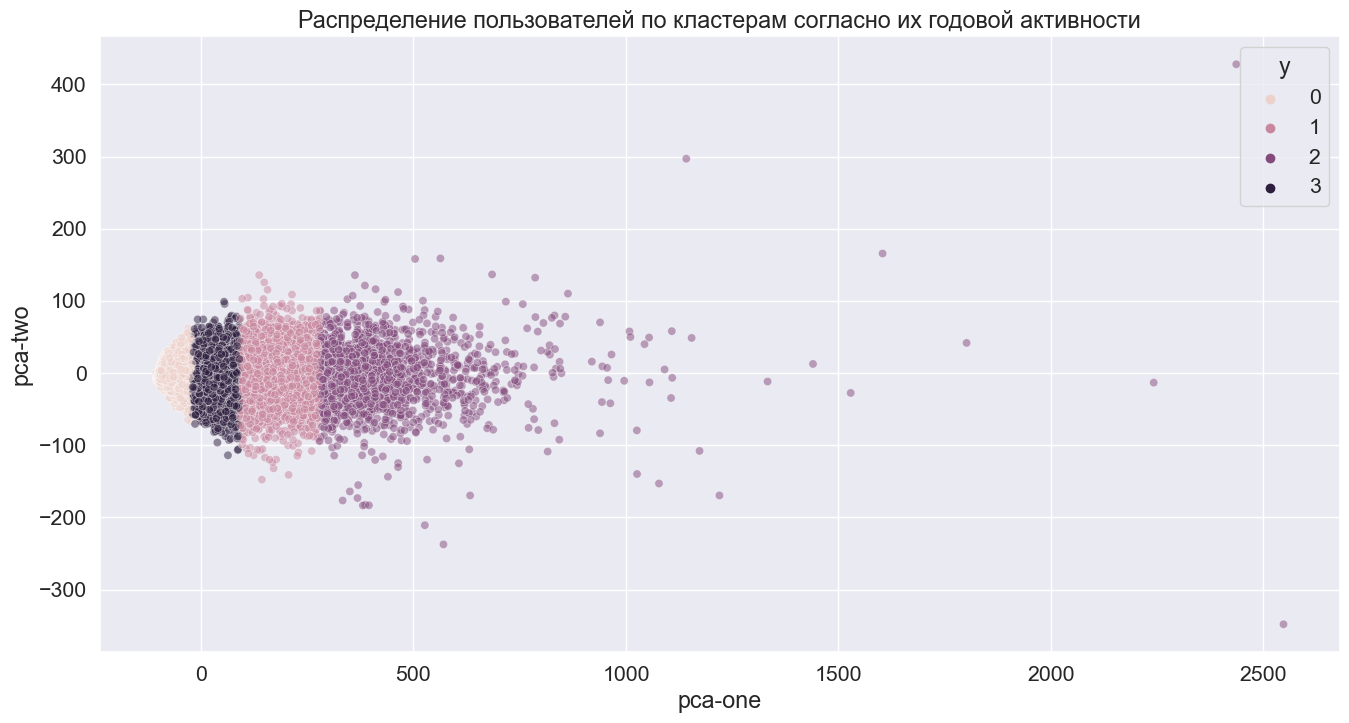

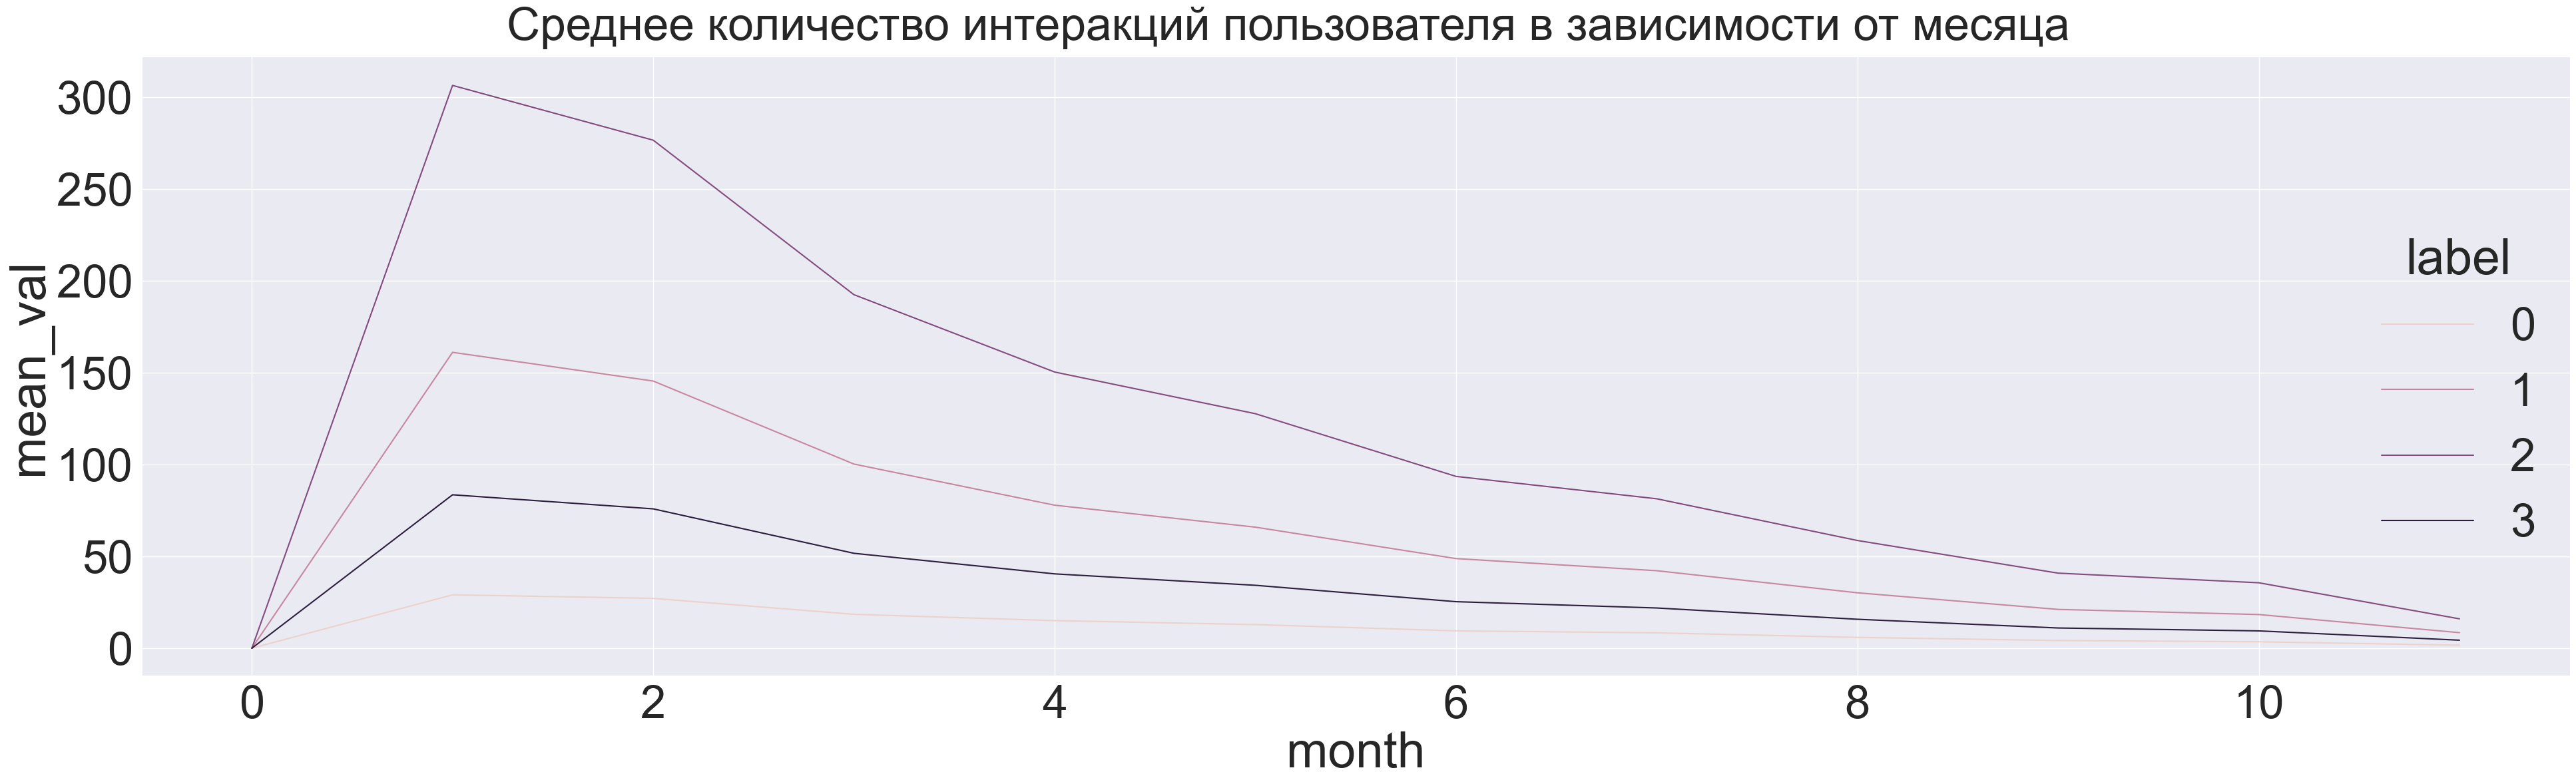

In [12]:
## Группировка по месяцам

n_clusters = 4
acceptable_hours = list(range(12))

grouped_df = df.groupby(['app_id', 'month'])['transaction_number'].count().reset_index(name='n_transaction_number')
grouped_df = grouped_df.groupby(['app_id'])[['month', 'n_transaction_number']].apply(lambda x: dict(x.values.tolist())).reset_index(name='transcation_per_sth')

grouped_dataset = defaultdict(list)

for app_id, transcation_per_sth in zip(grouped_df['app_id'], grouped_df['transcation_per_sth']):
    grouped_dataset['app_id'].append(app_id)
    
    for col in acceptable_hours:
        grouped_dataset[col].append(transcation_per_sth.get(col, 0))

grouped_df = pd.DataFrame(grouped_dataset)

## Кластеризация
kmeans = KMeans(n_clusters=n_clusters).fit(grouped_df[grouped_df.columns[1:]])
pedicted_clusters =  kmeans.predict(grouped_df[grouped_df.columns[1:]])

grouped_result_df = grouped_df[grouped_df.columns[1:]]
grouped_result_df['y'] = pedicted_clusters
grouped_mean_val = grouped_result_df.groupby('y').mean()

displied_df = pd.DataFrame()
displied_df['month'] = list(grouped_mean_val.T.index) * len(grouped_mean_val.values)

lables_list = []
mean_value_list = []

for label, mean_values in zip(list(grouped_mean_val.index), kmeans.cluster_centers_):
    for value in mean_values:
        lables_list.append(label)
        mean_value_list.append(value)

displied_df['mean_val'] = mean_value_list
displied_df['label'] = lables_list

## Снижение размерности
pca = PCA(n_components=2)
pca_result = pca.fit_transform(grouped_df[grouped_df.columns[1:]].values)

test_df = pd.DataFrame()
test_df['pca-one'] = pca_result[:,0]
test_df['pca-two'] = pca_result[:,1] 

test_df['y'] = pedicted_clusters

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

## Отрисовка графиков
fig, ax1 = plt.subplots(1)

ax1.set_title('Распределение пользователей по кластерам согласно их годовой активности')
ax1 = sns.scatterplot(
    ax=ax1,
    x="pca-one", y="pca-two",
    hue="y",
    data=test_df,
    legend="full",
    alpha=0.5
)

with sns.plotting_context("notebook", font_scale=4.5):
    ax2 = sns.relplot(data=displied_df, x="month", y="mean_val", hue="label", kind="line", height=12, aspect=3, legend="full")
    ax2.fig.suptitle('Среднее количество интеракций пользователя в зависимости от месяца', fontsize=50)

plt.tight_layout()

При распределении пользователей в зависимости от деятельности в разные месяца года можно выделить 4 профиля. 
* Все профили обладают повышенной активностью в феврале и имееют там пик активности, после чего активность пользователей уменьшается с каждым месяцем. Пользователи отличаются по интенсивности взаимодействия


In [13]:
yearly_cluster = pedicted_clusters

## Составление профиля клиентов по тратам


    app_id - Идентификатор заявки. заявки пронумерованы так, что более поздним заявкам соответствует более поздняя дата
    amnt - Нормированная сумма транзакции. 0.0 - соответствует пропускам
    currency - Идентификатор валюты транзакции
    operation_kind - Идентификатор типа транзакции
    card_type - Уникальный идентификатор типа карты
    operation_type - Идентификатор типа операции по пластиковой карте
    operationtypegroup - Идентификатор группы карточных операций, например, дебетовая карта или кредитная карта
    ecommerce_flag - Признак электронной коммерции
    payment_system - Идентификатор типа платежной системы
    income_flag - Признак списания/внесения денежных средств на карту
    mcc - Уникальный идентификатор типа торговой точки
    country - Идентификатор страны транзакции
    city - Идентификатор города транзакции
    mcc_category - Идентификатор категории магазина транзакции
    dayofweek - День недели, когда транзакция была совершена
    hour - Час, когда транзакция была совершена
    days_before - Количество дней до даты выдачи кредита
    weekofyear - Номер недели в году, когда транзакция была совершена
    hour_diff - Количество часов с момента прошлой транзакции для данного клиента
    transaction_number - Порядковый номер транзакции клиента


In [14]:
def kfold(data, folds):
    result = defaultdict(int)

    for val in data:
        result[folds[np.min(np.where(folds >= val))]] += 1
    
    return np.array([result.get(f, 0) for f in folds]).astype(float)

In [15]:
folds = np.array(range(11)) / 10

grouped_df = df.groupby('app_id')['amnt'].apply(list)
grouped_df = pd.DataFrame(grouped_df).reset_index()
X_normalized = preprocessing.normalize(list(grouped_df['amnt'].apply(lambda x: kfold(x, folds)).values), norm='l2')

In [16]:
## Кластеризация
kmeans = KMeans(n_clusters=3).fit(X_normalized)
pedicted_clusters =  kmeans.predict(X_normalized)

In [17]:
metrics.silhouette_score(X_normalized, kmeans.labels_, metric='euclidean')

0.3493308738685347

In [18]:
transactions_clusters = pedicted_clusters

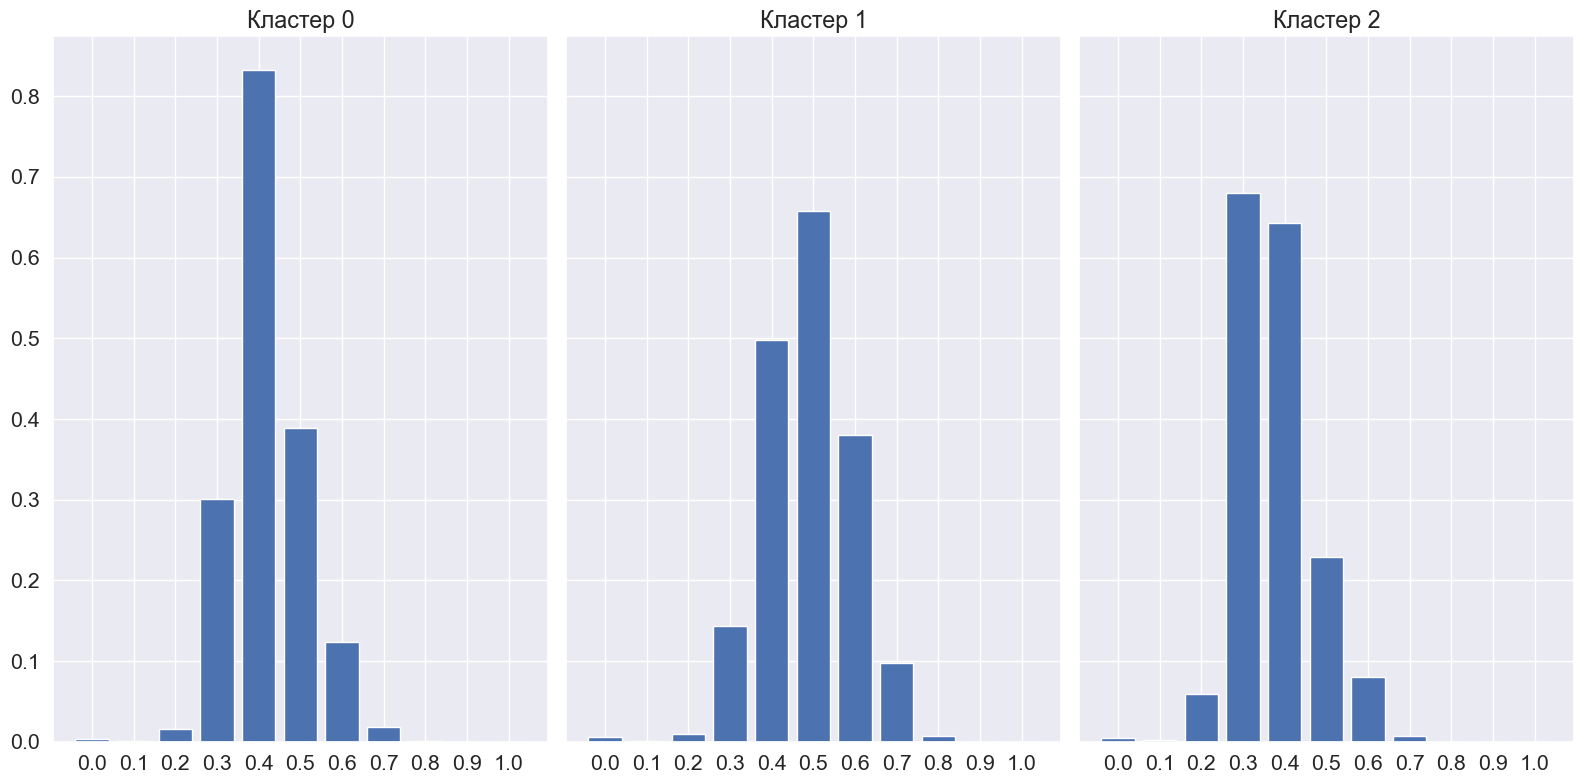

In [19]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

axs[0].bar([str(f) for f in folds], kmeans.cluster_centers_[0])
axs[0].set_title('Кластер 0')

axs[1].bar([str(f) for f in folds], kmeans.cluster_centers_[1])
axs[1].set_title('Кластер 1')

axs[2].bar([str(f) for f in folds], kmeans.cluster_centers_[2])
axs[2].set_title('Кластер 2');

При составлении профилей трат пользователей можно выделить 3 профиля
* Все траты пользователей в их профилях имеют форму распределения близку к нормальной
* Первый профиль пользователей имеет перекос в сторону средних покупок
* Второй профиль пользователей не имеет перекоса и имеет нормальные траты
* Третий профиль пользователей имеет перекос в сторону дешовых покупок


Explained variation per principal component: [0.54941675 0.25987483]


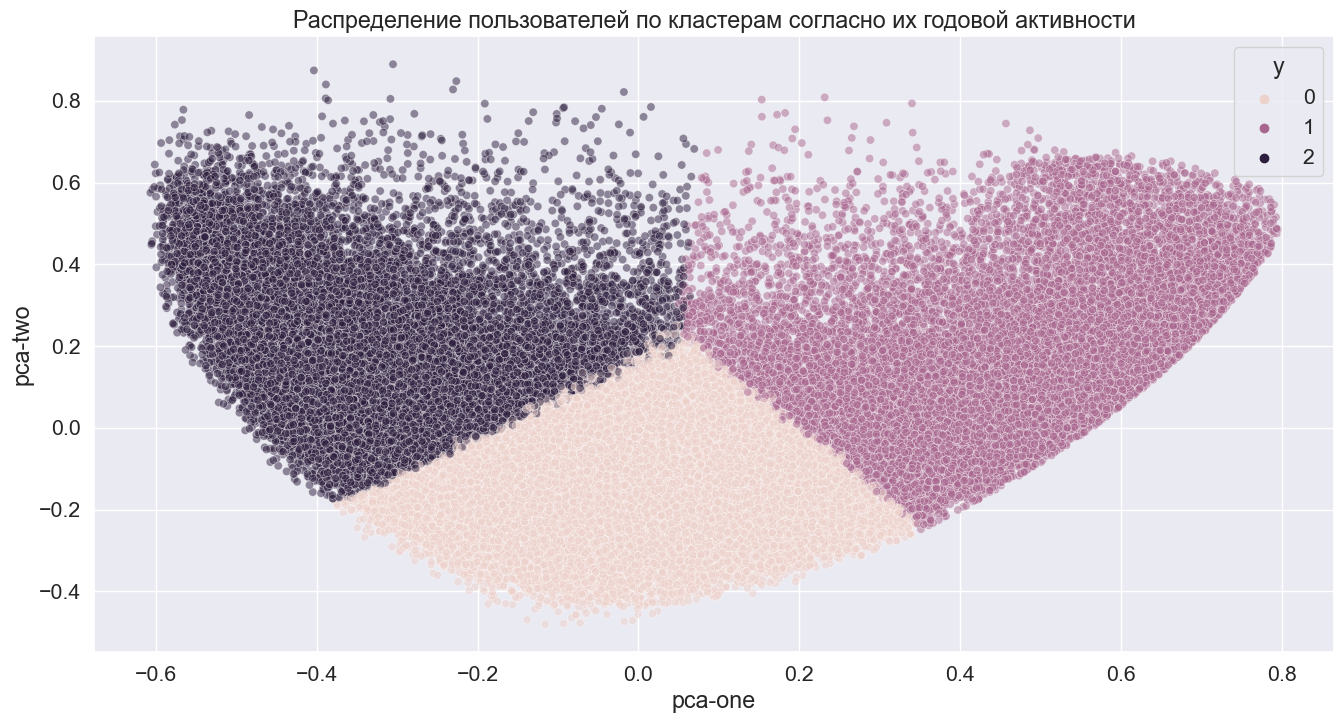

In [20]:
## Снижение размерности
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_normalized)

test_df = pd.DataFrame()
test_df['pca-one'] = pca_result[:,0]
test_df['pca-two'] = pca_result[:,1] 

test_df['y'] = pedicted_clusters

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

## Отрисовка графиков
fig, ax1 = plt.subplots(1)

ax1.set_title('Распределение пользователей по кластерам согласно их годовой активности')
ax1 = sns.scatterplot(
    ax=ax1,
    x="pca-one", y="pca-two",
    hue="y",
    data=test_df,
    legend="full",
    alpha=0.5
)

## Составление профилей интересов, опираясь на mcc-коды транзакций. 

In [40]:
needed_df = df.groupby(['app_id'])[['mcc', 'mcc_category']].apply(lambda x: x.values.tolist()).reset_index(name='mcc_codes')

needed_df['mcc_codes'] = needed_df['mcc_codes'].apply(lambda x: np.array(list(itertools.chain.from_iterable(x)), dtype=str))


In [41]:
# Создание словаря
id2word = corpora.Dictionary(needed_df['mcc_codes'].values)

corpus = [id2word.doc2bow(code) for code in needed_df['mcc_codes'].values]

print(corpus[:1])

[[(0, 63), (1, 9), (2, 8), (3, 1), (4, 3), (5, 3), (6, 1), (7, 203), (8, 4), (9, 2), (10, 2), (11, 1), (12, 2), (13, 1), (14, 2), (15, 2), (16, 3), (17, 1), (18, 11), (19, 17), (20, 21), (21, 2)]]


In [42]:
# Построение тематической модели LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [43]:
# Вычисление Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -2.5304619662297223


In [44]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    # Получение главного топика для каждого пользователя
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Получение главного топика и ключевых mcc для кажого пользователя
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => главный топик
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=needed_df['mcc_codes'].values[0])
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['app_id_num', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
df_dominant_topic.head(10)


C:\Users\Danila\AppData\Local\Temp\ipykernel_16396\2650879075.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Danila\AppData\Local\Temp\ipykernel_16396\2650879075.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,app_id_num,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9,0.5731,"2, 9, 78, 24, 11, 61, 45, 37, 47, 69",2
1,1,9,0.2766,"2, 9, 78, 24, 11, 61, 45, 37, 47, 69",2
2,2,1,0.3896,"1, 10, 7, 13, 15, 25, 31, 19, 2, 47",2
3,3,7,0.2590,"3, 4, 5, 6, 13, 32, 34, 1, 12, 10",2
4,4,9,0.4560,"2, 9, 78, 24, 11, 61, 45, 37, 47, 69",2
5,5,1,0.4297,"1, 10, 7, 13, 15, 25, 31, 19, 2, 47",2
6,6,9,0.2330,"2, 9, 78, 24, 11, 61, 45, 37, 47, 69",10
7,7,7,0.2924,"3, 4, 5, 6, 13, 32, 34, 1, 12, 10",7
8,8,1,0.3926,"1, 10, 7, 13, 15, 25, 31, 19, 2, 47",2
9,9,1,0.3395,"1, 10, 7, 13, 15, 25, 31, 19, 2, 47",2


In [45]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

C:\Users\Danila\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.208501 -0.265320       1        1  28.984776
9     -0.380632 -0.017473       2        1  19.277908
7      0.055670 -0.160928       3        1  17.089872
8      0.147207 -0.142870       4        1  11.813517
3      0.129595 -0.042427       5        1   8.843793
6      0.114192  0.062646       6        1   4.517679
2      0.186224  0.080807       7        1   3.942093
0     -0.168943  0.346189       8        1   2.787323
5     -0.024222  0.063476       9        1   2.742936
4      0.149410  0.075900      10        1   0.000103, topic_info=   Term          Freq         Total Category  logprob  loglift
0     1  1.709548e+07  1.709548e+07  Default  30.0000  30.0000
7     2  1.194609e+07  1.194609e+07  Default  29.0000  29.0000
12    3  4.879054e+06  4.879054e+06  Default  28.0000  28.0000
14    4  5.084664e+06  5.084664e+06  Default  27.0000  27.0000
33    5  3.355519e+06  3.355519e+06  Default  26.0000  26.0000
..  ...           ...           ...      ...      ...      ...
25   17  6.036280e-01  4.253827e+05  Topic10  -4.6821   0.3222
26   18  6.036280e-01  3.972815e+05  Topic10  -4.6821   0.3906
27   25  6.036280e-01  2.542556e+05  Topic10  -4.6821   0.8369
28   30  6.036280e-01  1.227703e+05  Topic10  -4.6821   1.5649
29   32  6.036280e-01  1.073769e+05  Topic10  -4.6821   1.6989

[415 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.997801    1
0         3  0.001678    1
0         4  0.000473    1
0         5  0.000046    1
0         9  0.000003    1
...     ...       ...  ...
100      10  0.000047   98
21        4  0.473960   99
21        5  0.500333   99
21        7  0.025617   99
21       10  0.000050   99

[539 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 8, 9, 4, 7, 3, 1, 6, 5])

При распределении пользователей по группам с приобладающими mcc-кодами можно выделить следующее 10 топиков на основе метрики Perplexity. При наведении на окружности можно увидель какие mcc-коды приобладают в той или иной теме

In [46]:
main_user_topic = df_dominant_topic['Dominant_Topic']

## Кластеризация пользователей по всем типам профилей и  визуализация распределения кластеров в пространстве сниженной размерности

In [47]:
final_df = pd.DataFrame()
final_df['app_id'] = needed_df['app_id']
final_df['weekly_cluster'] = weekly_cluster
final_df['daily_cluster'] = daily_cluster
final_df['yearly_cluster'] = yearly_cluster
final_df['transactions_profile_cluster'] = transactions_clusters
final_df['main_user_topic'] = main_user_topic

In [48]:
X_normalized = preprocessing.normalize(final_df[final_df.columns[1:]], norm='l2')

In [52]:
## Кластеризация
kmeans = KMeans(n_clusters=4).fit(X_normalized)
pedicted_clusters =  kmeans.predict(X_normalized)

In [53]:
metrics.silhouette_score(X_normalized, kmeans.labels_, metric='euclidean')

0.5000220225913704

Explained variation per principal component: [0.51874825 0.29539747]


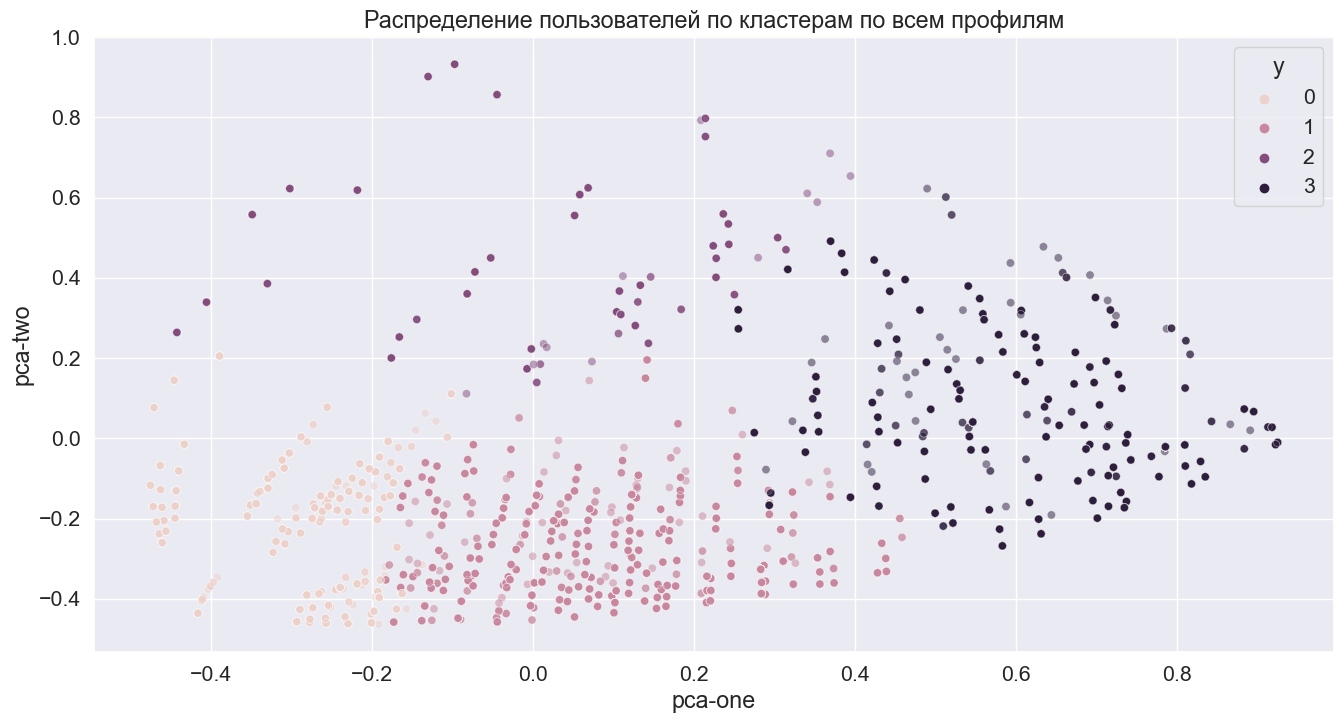

In [54]:
## Снижение размерности
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_normalized)

test_df = pd.DataFrame()
test_df['pca-one'] = pca_result[:,0]
test_df['pca-two'] = pca_result[:,1] 

test_df['y'] = pedicted_clusters

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

## Отрисовка графиков
fig, ax1 = plt.subplots(1)

ax1.set_title('Распределение пользователей по кластерам по всем профилям')
ax1 = sns.scatterplot(
    ax=ax1,
    x="pca-one", y="pca-two",
    hue="y",
    data=test_df,
    legend="full",
    alpha=0.5
)

При распределении пользователей в зависимости от деятельности в разные дни недели можно выделить 4 профиля. 
* Все профили обладают повышенной активностью в период со вторника по воскресенье и отличаются лишь интенсивностью активности
